In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ajayrana/hymenoptera-data")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ajayrana/hymenoptera-data/versions/1


In [3]:
!mkdir data
!cp -r /root/.cache/kagglehub/datasets/ajayrana/hymenoptera-data/versions/1/hymenoptera_data /content

mkdir: cannot create directory ‘data’: File exists


In [4]:
# !rm -rf /content/data

In [5]:
ddir="/content/hymenoptera_data/hymenoptera_data"

In [31]:
data_transformers = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])]),
    'val': transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])])}

img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k]) for k in ['train', 'val']}
dloaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8, shuffle=True)
            for k in ['train', 'val']}
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
img_data={k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k]) for k in ['train', 'val']}
dataloaders={k : torch.utils.data.DataLoader(img_data[k], batch_size=4, shuffle=True, num_workers=4) for k in ['train', 'val']}

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
img_data

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: /content/hymenoptera_data/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.49, 0.449, 0.411], std=[0.231, 0.221, 0.23])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: /content/hymenoptera_data/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.49, 0.449, 0.411], std=[0.231, 0.221, 0.23])
            )}

In [9]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fbf9f6fd4d0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fbf9f715c10>}

In [10]:
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
dset_sizes

{'train': 244, 'val': 153}

In [11]:
classes = img_data['train'].classes
classes

['ants', 'bees']

In [12]:
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dvc

device(type='cuda', index=0)

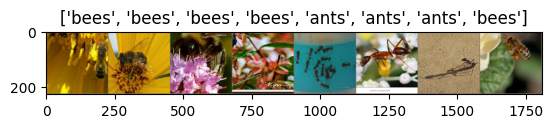

In [32]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

# Generate one train dataset batch
imgs, cls = next(iter(dloaders['train']))

# Generate a grid from batch
grid = torchvision.utils.make_grid(imgs)

imageshow(grid, text=[classes[c] for c in cls])

In [33]:
len(next(iter(dloaders['train'])))

2

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


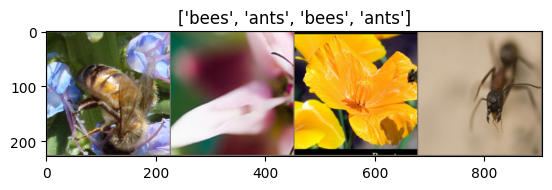

In [34]:
# Generate one train dataset batch
imgs, cls = next(iter(dataloaders['train']))

# Generate a grid from batch
grid = torchvision.utils.make_grid(imgs)

imageshow(grid, text=[classes[c] for c in cls])

In [48]:
def finetune_model(pretrained_model, loss_func, optim, epochs=10, dvc="cuda"):
    # move model to device
    pretrained_model.to(dvc)
    start = time.time()

    model_weights = copy.deepcopy(pretrained_model.state_dict())
    accuracy = 0.0

    for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print('=' * 20)

        for dset in ['train', 'val']:
            if dset == 'train':
                pretrained_model.train()
            else:
                pretrained_model.eval()

            loss = 0.0
            successes = 0

            for imgs, tgts in dloaders[dset]:
                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optim.zero_grad()

                with torch.set_grad_enabled(dset == 'train'):
                    ops = pretrained_model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)
                    if dset == 'train':
                        loss_curr.backward()
                        optim.step()

                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)

            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]

            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch
                model_weights = copy.deepcopy(pretrained_model.state_dict())
        print()

    time_delta = time.time() - start
    print(f'Training finished in {time_delta // 60}mins {time_delta % 60}secs')
    print(f'Best validation set accuracy: {accuracy}')

    pretrained_model.load_state_dict(model_weights)
    return pretrained_model


In [49]:
def visualize_predictions(pretrained_model, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs.to(dvc)
            tgts = tgts.to(dvc)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)

            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgts[j]]}')
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

In [50]:
model_finetune = models.alexnet(pretrained=True)
print(model_finetune.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [51]:
print(model_finetune.classifier)


Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [52]:
import torch.optim as optim


In [53]:
# change the last layer from 1000 classes to 2 classes
model_finetune.classifier[6] = nn.Linear(4096, len(classes))

loss_func = nn.CrossEntropyLoss()
optim_finetune = optim.SGD(model_finetune.parameters(), lr=0.0001)

# train (fine-tune) and validate the model
model_finetune = finetune_model(model_finetune, loss_func, optim_finetune, epochs=10)

Epoch number 0/9
train loss in this epoch: 0.8004511409118528, accuracy in this epoch: 0.4877049180327869
val loss in this epoch: 0.6700246328232335, accuracy in this epoch: 0.6143790849673203

Epoch number 1/9
train loss in this epoch: 0.6253837102749309, accuracy in this epoch: 0.6475409836065574
val loss in this epoch: 0.545804498242397, accuracy in this epoch: 0.7581699346405228

Epoch number 2/9
train loss in this epoch: 0.4913443278093807, accuracy in this epoch: 0.7704918032786886
val loss in this epoch: 0.48334970154793433, accuracy in this epoch: 0.7908496732026145

Epoch number 3/9
train loss in this epoch: 0.46265513046843104, accuracy in this epoch: 0.7704918032786886
val loss in this epoch: 0.43874357572568007, accuracy in this epoch: 0.8104575163398693

Epoch number 4/9
train loss in this epoch: 0.43247067048901416, accuracy in this epoch: 0.7991803278688525
val loss in this epoch: 0.40229443974452084, accuracy in this epoch: 0.823529411764706

Epoch number 5/9
train loss

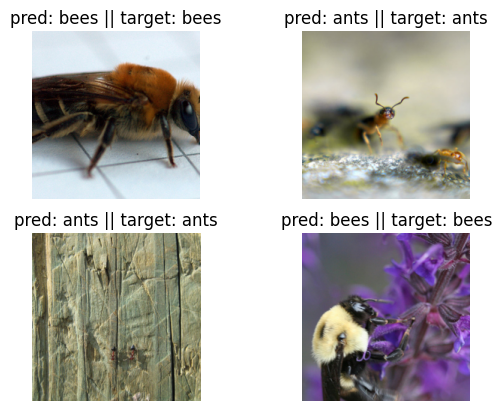

In [54]:
visualize_predictions(model_finetune)
